In [ ]:
import pathlib
import rasterio
import numpy as np
import pandas as pd
import torch
from PIL import Image
# Written Utils Functions
from Utils.utils import build_embedding_model, compute_image_embeddings
from Utils.utils import compute_tabular_features
from Utils.utils import compute_multi_embeddings
# Writtent Model Functions
from Utils.computation import compute_pca_components
from Utils.computation import estimate_treatment_effect_tabular 
from Utils.computation import estimate_treatment_effect_with_embeddings
from Utils.computation import evaluate_ite, get_train_test_indices

In [5]:
# Collect file paths
DATA_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data')
SYNTH_DIR = pathlib.Path('/Users/sayedmorteza/Library/CloudStorage/Box-Box/Hetwet_Data/Synthetic')

folders = {
    'wet': SYNTH_DIR / 'Treatment',
    'dem': DATA_DIR / 'DEM',
    'cap': DATA_DIR / 'CAPITAL_1996',
    'outcome_pre': SYNTH_DIR / 'Outcome',
    'outcome_post': SYNTH_DIR / 'Outcome_post',
    'ite_direct': SYNTH_DIR / 'ITE_Direct',
    'ite_indirect': SYNTH_DIR / 'ITE_Indirect',
    'ite_total': SYNTH_DIR / 'ITE_Total',
    'theta_directXout': SYNTH_DIR / 'Theta_DirectXout',
    'theta_out': SYNTH_DIR / 'Theta_out',
    'theta': SYNTH_DIR / 'Theta'

}


scene_ids = [str(i) for i in range(1, 3566)]

In [10]:
# Tabular features
tab_df = compute_tabular_features(folders, scene_ids)
tab_df.head()

Saved features to: /Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Model/features.csv


,scene_id,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,...,ite_indirect_mean,ite_indirect_std,ite_total_mean,ite_total_std,theta_directXout_mean,theta_directXout_std,theta_out_mean,theta_out_std,theta_mean,theta_std
0,1,0.768158,0.422009,64.378952,22.386531,0.0,0.0,0.095600,0.082439,0.592143,...,0.192427,0.022821,0.592143,0.074387,0.477758,0.004904,0.249100,0.003187,0.522187,0.006542
1,2,0.905380,0.292689,94.023680,23.789066,0.0,0.0,0.085011,0.094904,0.687272,...,0.221940,0.018396,0.687272,0.060696,0.477727,0.004776,0.245665,0.002547,0.514523,0.004503
2,3,0.947266,0.223503,103.384105,15.987604,0.0,0.0,0.103364,0.110441,0.716351,...,0.230953,0.006072,0.716351,0.021634,0.477494,0.006091,0.244617,0.002754,0.512433,0.001725
3,4,0.904892,0.293364,88.248975,15.052856,0.0,0.0,0.073378,0.102897,0.687237,...,0.221973,0.008372,0.687237,0.028149,0.477468,0.005285,0.245616,0.002387,0.514598,0.001989
4,5,0.901764,0.297634,86.249280,11.162309,0.0,0.0,0.101699,0.105849,0.685333,...,0.221186,0.007220,0.685333,0.023589,0.478443,0.005521,0.246197,0.002536,0.514765,0.001646


In [11]:
tab_df.describe()

,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,outcome_post_std,...,ite_indirect_mean,ite_indirect_std,ite_total_mean,ite_total_std,theta_directXout_mean,theta_directXout_std,theta_out_mean,theta_out_std,theta_mean,theta_std
count,3565.000000,3565.000000,3565.000000,3565.000000,3.565000e+03,3.565000e+03,3565.000000,3565.000000,3565.000000,3565.000000,...,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000
mean,0.476978,0.438636,-433.918692,216.401709,4.197241e+04,2.520522e+05,0.088260,0.103333,0.563317,0.169577,...,0.153126,0.055582,0.562629,0.167983,0.364155,0.044436,0.282563,0.067402,0.975653,0.081527
std,0.222265,0.087651,1861.773938,907.998179,1.721724e+05,1.280287e+06,0.031501,0.036385,0.290272,0.167549,...,0.100805,0.054353,0.289223,0.163792,0.173147,0.058247,0.152661,0.075683,0.472009,0.101129
min,0.000000,0.000000,-9999.000000,0.000000,0.000000e+00,0.000000e+00,-0.037903,0.068268,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.512433,0.000000
25%,0.283569,0.431335,1.727104,0.834537,0.000000e+00,0.000000e+00,0.078307,0.093528,0.397081,0.035289,...,0.100549,0.012612,0.397081,0.035289,0.303254,0.004649,0.245422,0.016070,0.594605,0.006284
50%,0.461670,0.463339,9.806548,2.776222,2.873736e+03,2.000996e+04,0.088619,0.099797,0.501184,0.125653,...,0.147889,0.041927,0.501164,0.125512,0.469674,0.011278,0.283418,0.037672,0.726507,0.054783
75%,0.650833,0.490401,30.674374,7.810327,2.278676e+04,7.562379e+04,0.098953,0.106725,0.661924,0.240558,...,0.204901,0.079262,0.661709,0.239823,0.477697,0.073919,0.354199,0.090929,1.478360,0.094919
max,0.982178,0.500000,103.384105,4999.444138,6.145465e+06,3.960960e+07,0.889573,1.322401,2.306652,1.371915,...,0.691308,0.308193,2.306652,0.912484,0.479364,0.222251,0.835682,0.375372,1.862583,0.492163


## SINGLE LAYER EMBEDDINGS

In [33]:
# Embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_embedding_model(
    device=device,
    model_type='resnet18', 
    conv_layer=4             
)

# Compute image embeddings for each variable
# for var in folders:
#     _ = compute_image_embeddings(
#         folders=folders,
#         scene_ids=scene_ids,
#         var=var,
#         model=model,
#         device=device,
#         img_size=256,
#     )

# Compute image embeddings for only wetland
var = 'wet'
_ = compute_image_embeddings(
    folders=folders,
    scene_ids=scene_ids,
    var=var,
    model=model,
    device=device,
    img_size=256,
)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Embedding wet scenes: 100%|██████████| 3565/3565 [12:55<00:00,  4.60it/s]


Saved embeddings to: /Users/sayedmorteza/Library/CloudStorage/Box-Box/Caltech Research/Scripts/ImageTRT/Model/wet_embeddings.csv


In [38]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=10)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca10.csv")

In [39]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=50)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca50.csv")

In [40]:
# Get pca features
pca_wet = compute_pca_components('wet_embeddings.csv', n_components=100)
# pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("wet_pca100.csv")

## Multi Band Embeddings

In [12]:
# Embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_embedding_model(
    device=device,
    model_type='resnet18', 
    conv_layer=4             
)
# Running multi-layer embeddings
vars = ['wet', 'dem', 'cap']
_ = compute_multi_embeddings(
    folders=folders,
    scene_ids=scene_ids,
    vars=vars,
    model=model,
    device=device,
    img_size=256
)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Embedding stacked scenes:   0%|          | 0/3565 [00:00<?, ?it/s]Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
invalid value encountered in divide
invalid value encountered in cast
Embedding stacked scenes: 100%|██████████| 3565/3565 [25:18<00:00,  2.35it/s]


In [15]:
# Get pca features
pca_wet = compute_pca_components('stacked_embeddings.csv', n_components=100)
# # pca_dem = compute_pca_components('dem_embeddings.csv', n_components=2)
# # pca_cap = compute_pca_components('cap_embeddings.csv', n_components=2)
# # pca_claims_96 = compute_pca_components('claims_96_embeddings.csv', n_components=2)

pca_wet.to_csv("stacked_wet_pca100.csv")

## Get Synthetic Data for Spillovers Outgoing

In [6]:
import numpy as np
from scipy.signal import fftconvolve

def make_exp_kernel(lam_m, cell_size_m, truncate=4):
    """
    Build a normalized 2D exponential‐decay kernel:
      K(d) = exp(−d/lam_m), truncated at 4·lam_m.
    """
    R = int(truncate * lam_m / cell_size_m)
    y, x = np.ogrid[-R:R+1, -R:R+1]
    d    = np.hypot(x, y) * cell_size_m
    K    = np.exp(-d/lam_m)
    K   /= K.sum()
    return K


def exp_convolve(arr: np.ndarray, K: np.ndarray) -> np.ndarray:
    """
    Convolve a 2D array `arr` with kernel `K` using FFT, returning an array of the same shape.

    Parameters
    ----------
    arr : np.ndarray
        Input 2D array to be convolved.
    K : np.ndarray
        2D kernel array.

    Returns
    -------
    out : np.ndarray
        Convolved array, same shape as `arr`.
    """
    # Ensure float32 for speed and precision
    return fftconvolve(arr.astype(np.float32), K.astype(np.float32), mode='same')


In [7]:
def downstream_only_KuT(T, DEM, theta, K):
    H, W = T.shape
    R    = K.shape[0] // 2

    # pad inputs…
    T_pad     = np.pad(T,     R, mode='constant', constant_values=0.0)
    theta_pad = np.pad(theta, R, mode='constant', constant_values=0.0)
    DEM_pad   = np.pad(DEM,   R, mode='edge')

    # preallocate all three outputs
    S_src            = np.zeros((H, W), dtype=np.float32)
    Theta_directXout = np.zeros((H, W), dtype=np.float32)
    W_sum            = np.zeros((H, W), dtype=np.float32)

    for i in range(H):
        for j in range(W):
            center_elev = DEM_pad[i+R, j+R]
            t_i         = T_pad[i+R, j+R]
            theta_i     = theta_pad[i+R, j+R]

            dem_patch       = DEM_pad[i:i+2*R+1, j:j+2*R+1]
            downstream_mask = (dem_patch < center_elev).astype(np.float32)
            w               = np.sum(K * downstream_mask)

            # store into each array at (i,j)
            W_sum[i, j]            = w
            Theta_directXout[i, j] = theta_i * w
            S_src[i, j]            = theta_i * t_i * w

    return S_src, Theta_directXout, W_sum

In [8]:
import logging
from pathlib import Path
import numpy as np
import rasterio as rio
from PIL import Image

def load_and_resize(path: Path, shape: tuple[int, int], resample) -> np.ndarray:
    """
    Load a single-band image from `path`, resize to `shape`, and return as a numpy array.
    """
    if not path.exists():
        logging.warning(f"File not found: {path}")
        return None
    with rio.open(path) as src:
        arr = src.read(1)
    dtype = np.uint8 if resample == Image.NEAREST else np.float32
    img = Image.fromarray(arr)
    resized = img.resize(shape, resample)
    return np.array(resized, dtype=dtype)


In [9]:
from pathlib import Path
import os
import numpy as np
import random
from PIL import Image

def to_coarse(arr256, target_shape=(8, 8), mode=Image.BILINEAR):
    """Resize a 256×256 NumPy array to an 8×8 array."""
    im  = Image.fromarray(arr256.astype(np.float32), mode='F')
    imC = im.resize(target_shape[::-1], resample=mode)  # PIL uses (W,H)
    return np.array(imC, dtype=np.float32)

random.seed(42)

# build your spillover kernel
CELL_SIZE = 30 # cell size in meters
LAMBDA    = 100.0
TRUNCATE = 1
KERNEL    = make_exp_kernel(lam_m=LAMBDA, cell_size_m=CELL_SIZE, truncate=TRUNCATE)
print(f"Number of Affected Nearby Squares: {KERNEL.shape}")

base = (
        '~/Library/CloudStorage/Box-Box/Hetwet_Data/Synthetic'
        )
results_dir = Path(os.path.expanduser(base))
results_dir.mkdir(parents=True, exist_ok=True)

# Theta dir
theta_out_dir      = results_dir / 'Theta_out'
theta_out_dir.mkdir(parents=True, exist_ok=True)

# Theta dir
theta_directXout_dir      = results_dir / 'Theta_DirectXout'
theta_directXout_dir.mkdir(parents=True, exist_ok=True)


i = 1 
for sid in scene_ids:
        # Paths
        i += 1
        paths = {
                'dem':     Path(folders['dem'])      / f"DEM_{sid}.tiff",
                'cap':     Path(folders['cap'])      / f"CAPITAL_1996_{sid}.tiff",
                'wet':     Path(folders['wet'])      / f"treatment_scene_{sid}_gaussian.tiff",
                'theta':    Path(folders['theta'])      / f"theta_{sid}.tiff",
                }

        # changing the
        target_shape = (256, 256)
        # Load & resize to WETLAND size
        dem_r    = load_and_resize(paths['dem'],    target_shape, Image.BILINEAR)
        cap_r    = load_and_resize(paths['cap'],    target_shape, Image.BILINEAR)
        treat_r  = load_and_resize(paths['wet'],  target_shape, Image.NEAREST)
        

        # Cast
        dem   = dem_r.astype(np.float32)
        cap   = cap_r.astype(np.float32)
        treat = treat_r.astype(np.float32)
        
        Bbase = 0.5
        Beta1 = 0.05
        Beta2 = 2.5

        # Compute θ(x)
        dem_safe = np.maximum(dem, 1.0)
        theta = Bbase * (1.0
                         + Beta1 * np.log1p(cap)
                         + Beta2 / dem_safe)

        # 2) spillover that i produces on *other* pixels -----------------
        _, theta_out, theta_directXout  = downstream_only_KuT(treat, dem, theta, KERNEL)  # (H,W)

        coarse_shape = (8, 8)
        # Resize ITES to coarse grid
        theta_out       = to_coarse(theta_out, coarse_shape, Image.BILINEAR)
        theta_directXout = to_coarse(theta_directXout, coarse_shape, Image.BILINEAR)

        if i % 50 == 0:
            print(f"Processed scene {i}")

        Image.fromarray(theta_out.astype(np.float32), mode='F').save(
            theta_out_dir / f"Theta_scene_{sid}.tiff")
        Image.fromarray(theta_directXout.astype(np.float32), mode='F').save(
            theta_directXout_dir / f"Theta_DirectXout_scene_{sid}.tiff")

Number of Affected Nearby Squares: (7, 7)
Processed scene 50
Processed scene 100
Processed scene 150
Processed scene 200
Processed scene 250
Processed scene 300
Processed scene 350
Processed scene 400
Processed scene 450
Processed scene 500
Processed scene 550
Processed scene 600
Processed scene 650
Processed scene 700
Processed scene 750
Processed scene 800
Processed scene 850
Processed scene 900
Processed scene 950
Processed scene 1000
Processed scene 1050
Processed scene 1100
Processed scene 1150
Processed scene 1200
Processed scene 1250
Processed scene 1300
Processed scene 1350
Processed scene 1400
Processed scene 1450
Processed scene 1500
Processed scene 1550
Processed scene 1600
Processed scene 1650
Processed scene 1700
Processed scene 1750
Processed scene 1800
Processed scene 1850
Processed scene 1900
Processed scene 1950
Processed scene 2000
Processed scene 2050
Processed scene 2100
Processed scene 2150
Processed scene 2200
Processed scene 2250
Processed scene 2300
Processed sc

In [25]:
print(theta_out)
print(theta_directXout)
print(theta[1,1])

0.20729218572599895
0.4050691711652188
0.5282167


## Models

In [10]:
# combine features
# combined_df = combine_features(
#     tab_df,
#     pca_wet=pca_wet,
#     pca_dem=pca_dem,
#     pca_cap=pca_cap,
#     pca_claims_96=pca_claims_96
# )

In [41]:
tab_df.head()

,scene_id,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,outcome_post_std,theta_mean,theta_std
0,1,0.768158,0.422009,64.378952,22.386531,0.0,0.0,0.095600,0.082439,0.592143,0.074387,0.522187,0.006542
1,2,0.905380,0.292689,94.023680,23.789066,0.0,0.0,0.085011,0.094904,0.687272,0.060696,0.514523,0.004503
2,3,0.947266,0.223503,103.384105,15.987604,0.0,0.0,0.103364,0.110441,0.716351,0.021634,0.512433,0.001725
3,4,0.904892,0.293364,88.248975,15.052856,0.0,0.0,0.073378,0.102897,0.687237,0.028149,0.514598,0.001989
4,5,0.901764,0.297634,86.249280,11.162309,0.0,0.0,0.101699,0.105849,0.685333,0.023589,0.514765,0.001646


In [ ]:
# number of PC
n = 10

# load tables
tab_df     = pd.read_csv('features.csv')
pca_wet    = pd.read_csv(f"stacked_wet_pca{n}.csv")

# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean', 'dem_std', 'cap_std']

# merge PCA back onto tab_df
df = tab_df.merge(pca_wet,  on='scene_id', how='left')

COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
# split once
train_idx, test_idx = get_train_test_indices(tab_df, test_size=0.2, random_state=42)

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {COVS_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean', 'dem_std', 'cap_std']
Image Covariates: ['dem_mean', 'cap_mean', 'dem_std', 'cap_std', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']


In [62]:
# tabular-only
cate_tab, ate_tab, model_tab = estimate_treatment_effect_tabular(
    df=df,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS
)

In [85]:
# image
cate_img, ate_img, model_img = estimate_treatment_effect_tabular(
    df=df,
    train_idx=train_idx,
    test_idx=test_idx,
    outcome_col=OUTCOME,
    treatment_col=TREAT,
    covariate_cols=COVS_IMAGE
)

In [50]:
# Actual ITE
cate_true = tab_df[['scene_id', 'theta_mean']]

In [51]:
np.mean(cate_true['theta_mean'])

Tabular ATE (train/test): {'ate_train': 1.6641753027091006, 'ate_test': 1.6078538608397699}
Image‐augmented ATE (train/test): {'ate_train': 1.0336224076345637, 'ate_test': 1.0348487312799697}


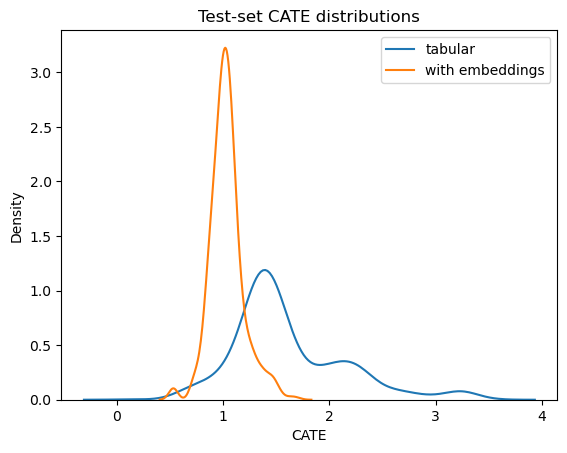

In [64]:
print("Tabular ATE (train/test):", ate_tab)
print("Image‐augmented ATE (train/test):", ate_img)

# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab.query("dataset=='test'")['CATE'], label='tabular')
sns.kdeplot(cate_img.query("dataset=='test'")['CATE'], label='with embeddings')
plt.legend(); plt.title("Test‐set CATE distributions")
plt.show()

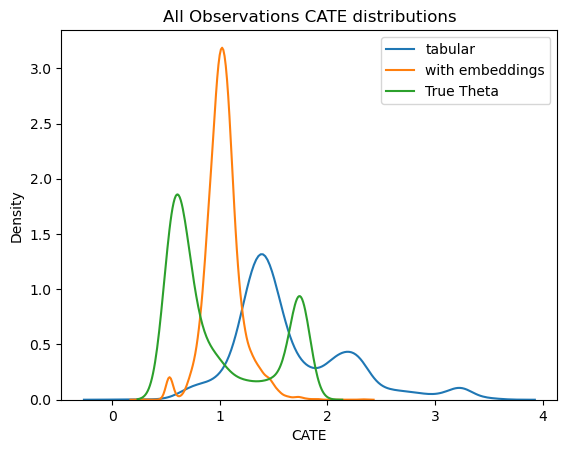

In [65]:
# ompare out‐of‐sample CATE distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(cate_tab['CATE'], label='tabular')
sns.kdeplot(cate_img['CATE'], label='with embeddings')
sns.kdeplot(cate_true['theta_mean'], label='True Theta')
plt.legend(); plt.title("All Observations CATE distributions")
# plt.xlim(0, 3)
plt.show()

In [86]:
df_actual = cate_true
df_estimated = cate_img
id_col = "scene_id"
actual_col = "theta_mean"
estimated_col = "CATE"

In [87]:

df = pd.merge(
    df_actual[[id_col, actual_col]],
    df_estimated[[id_col, estimated_col, "dataset"]],
    on=id_col,
    how="left",
)
df.head()

,scene_id,theta_mean,CATE,dataset
0,1,0.522187,1.248708,test
1,2,0.514523,0.911707,train
2,3,0.512433,0.777895,train
3,4,0.514598,0.879000,train
4,5,0.514765,0.690169,train


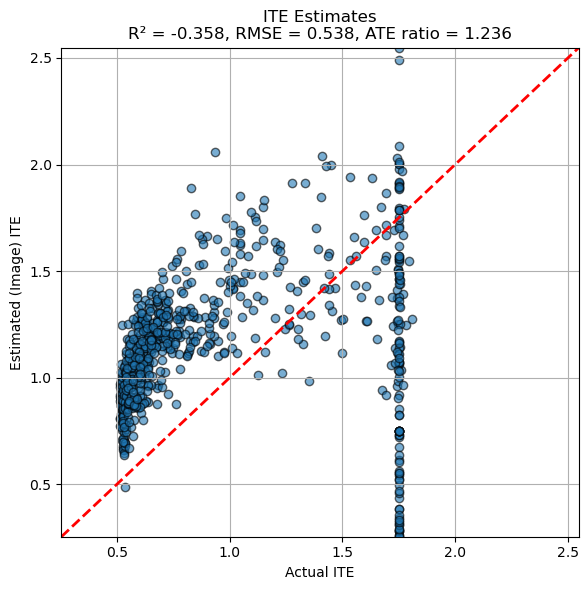

In [88]:
from sklearn.metrics import r2_score, mean_squared_error

df = df[df['dataset'] == "test"]

# 2) Extract arrays
y_true = df[actual_col].to_numpy()
y_pred = df[estimated_col].to_numpy()

# 3) Compute metrics
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
ate_true = y_true.mean()
ate_pred = y_pred.mean()
ate_ratio = ate_pred / ate_true if ate_true != 0 else np.nan

# 4) Scatter plot actual vs. estimated
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolor="k")
lo = min(y_true.min(), y_pred.min())
hi = max(y_true.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], "r--", lw=2)
plt.xlim(lo, hi)
plt.ylim(lo, hi)
plt.xlabel("Actual ITE")
plt.ylabel("Estimated (Image) ITE")
plt.title(
    f"ITE Estimates\nR² = {r2:.3f}, RMSE = {rmse:.3f}, ATE ratio = {ate_ratio:.3f}"
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
ate_true
ate_pred

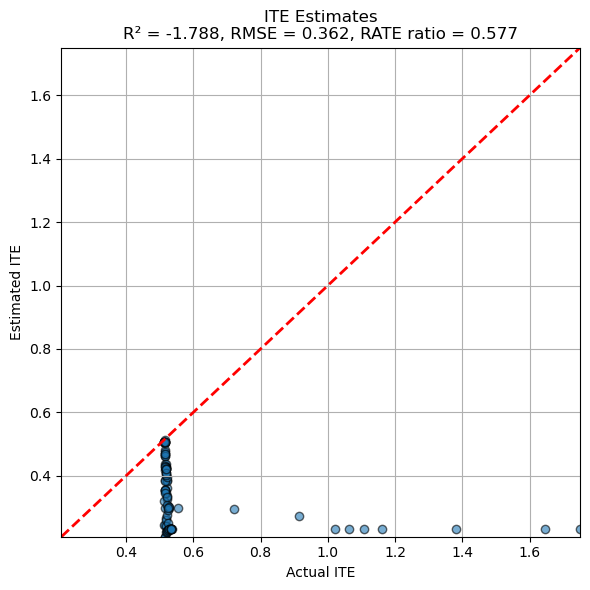

Saved histograms to:
  results/ite_plots/hist_actual_ite.png
  results/ite_plots/hist_estimated_ite.png
{'r2': -1.7875062990789927, 'rmse': 0.3615093002799662, 'rate_ratio': 0.5773558844927247}


In [18]:
# evaluating ITE with the actual data for tabular
metrics = evaluate_ite(
    cate_true,
    cate_tab,
    id_col="scene_id",
    actual_col="theta_mean",
    estimated_col="CATE",
    output_dir="results/ite_plots"
)
print(metrics)

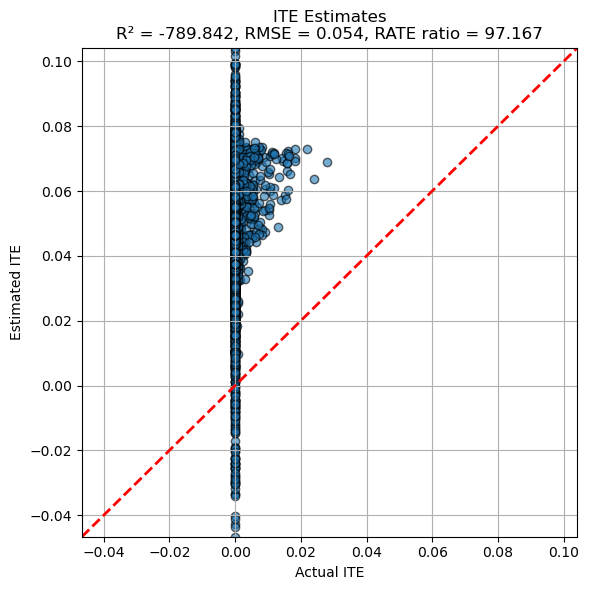

Saved histograms to:
  results/ite_plots/hist_actual_ite.png
  results/ite_plots/hist_estimated_ite.png
{'r2': -789.8421587103322, 'rmse': 0.05385770552831608, 'rate_ratio': 97.16689784155963}


In [7]:
# evaluating ITE with the actual data for tabular
metrics = evaluate_ite(
    cate_true,
    cate_tab,
    id_col="scene_id",
    actual_col="ite_mean",
    estimated_col="CATE",
    output_dir="results/ite_plots"
)
print(metrics)

## Linear Regression

In [53]:
# number of PC
n = 50

# load tables
tab_df     = pd.read_csv('features.csv')
pca_wet    = pd.read_csv(f"stacked_wet_pca{n}.csv")

# outcome variable
tab_df['outcome'] = tab_df['outcome_post_mean'] - tab_df['outcome_pre_mean']

# pick outcome & features
OUTCOME = 'outcome'
TREAT   = 'wet_mean'
# COVS    = [c for c in tab_df.columns 
#           if c not in ('scene_id', OUTCOME, 'wet_mean', 'outcome', 'claims_16_mean', 'claims_96_mean')]
COVS = ['dem_mean', 'cap_mean']

# merge PCA back onto tab_df
df = tab_df.merge(pca_wet,  on='scene_id', how='left')

COVS_IMAGE  = COVS + [f'PC{i+1}' for i in range(n)]
# split once
train_idx, test_idx = get_train_test_indices(tab_df, test_size=0.2, random_state=42)

print(f"Outomce Columns:{OUTCOME}")
print(f"Treatment Column: {TREAT}")
print(f"Tabular Covariates: {COVS}")
print(f"Image Covariates: {COVS_IMAGE}")

Outomce Columns:outcome
Treatment Column: wet_mean
Tabular Covariates: ['dem_mean', 'cap_mean']
Image Covariates: ['dem_mean', 'cap_mean', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50']


### TABULAR LINEAR REGRESSION

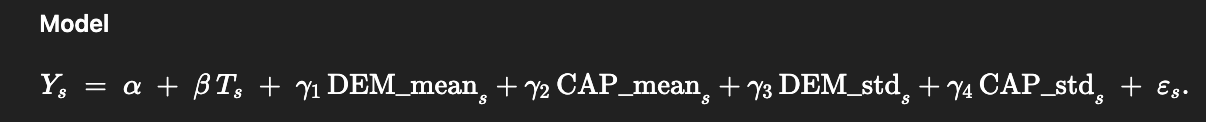

## Normalize DEM AND CAPITAL!!!

## CAUSAL FOREST

In [54]:
import statsmodels.api as sm

Y = tab_df[OUTCOME]

X_tab = [TREAT] + COVS

X_tab = sm.add_constant(tab_df[X_tab])

model_tab = sm.OLS(Y, X_tab).fit()
print(model_tab.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     1387.
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:10:17   Log-Likelihood:                 934.03
No. Observations:                3565   AIC:                            -1860.
Df Residuals:                    3561   BIC:                            -1835.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1094      0.009     12.567      0.0

### IMAGE 

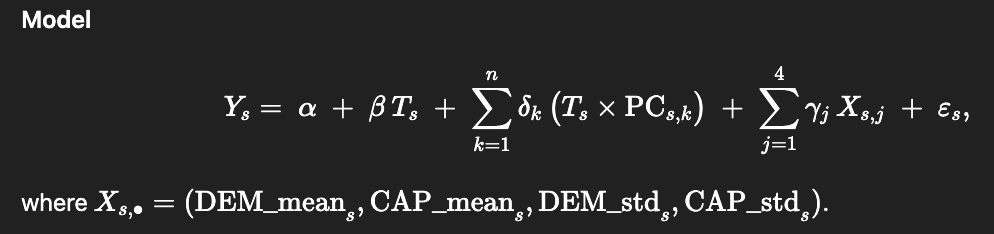

In [55]:
df = tab_df.merge(pca_wet,  on='scene_id', how='left')

for k in range(1, n+1):
    df[f'T_PC{k}'] = df['wet_mean'] * df[f'PC{k}']



In [56]:
df.head()

,scene_id,wet_mean,wet_std,dem_mean,dem_std,cap_mean,cap_std,outcome_pre_mean,outcome_pre_std,outcome_post_mean,...,T_PC41,T_PC42,T_PC43,T_PC44,T_PC45,T_PC46,T_PC47,T_PC48,T_PC49,T_PC50
0,1,0.768158,0.422009,64.378952,22.386531,0.0,0.0,0.095600,0.082439,0.592143,...,-0.043212,-0.287406,-0.193393,-0.439305,0.204703,0.168984,0.250272,0.410121,0.087965,0.097643
1,2,0.905380,0.292689,94.023680,23.789066,0.0,0.0,0.085011,0.094904,0.687272,...,0.259699,0.309136,0.480418,-0.220282,-0.555806,-0.269329,0.413826,-0.211031,0.133723,0.255261
2,3,0.947266,0.223503,103.384105,15.987604,0.0,0.0,0.103364,0.110441,0.716351,...,1.943760,0.950752,0.981964,-0.638699,-0.098527,-0.309002,-0.103281,-1.284502,0.330340,0.552548
3,4,0.904892,0.293364,88.248975,15.052856,0.0,0.0,0.073378,0.102897,0.687237,...,0.731197,0.022763,0.504222,-0.610031,0.212125,0.171259,-0.326836,-0.451787,0.753855,0.328006
4,5,0.901764,0.297634,86.249280,11.162309,0.0,0.0,0.101699,0.105849,0.685333,...,-0.014420,-0.076328,0.102932,0.341844,0.257858,-1.020110,-0.832270,0.063336,0.160580,0.049072


In [57]:
inter_actions = [f'T_PC{k}' for k in range(1, n+1)]
X_img = df[[TREAT] + inter_actions + COVS_IMAGE]
X_img = sm.add_constant(X_img)

Y = df[OUTCOME]

model_img = sm.OLS(Y, X_img).fit()
print(model_img.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     308.0
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:10:29   Log-Likelihood:                 3687.6
No. Observations:                3565   AIC:                            -7167.
Df Residuals:                    3461   BIC:                            -6525.
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0317      0.020      1.568      0.1

In [58]:
# 1) the main treat coefficient
β_t = model_img.params['wet_mean']

print("Estimated ATE components from Tabular regression:")
print(f"β_treatment = {β_t:.4f}")

Estimated ATE components from Tabular regression:
β_treatment = 0.8775


In [59]:
# 1) the main treat coefficient
β_t = model_img.params['wet_mean']

# 2) the interaction coefficients
inter_cols = [f'T_PC{k}' for k in range(1, 11)]
β_int = model_img.params[inter_cols].sum()

# 3) total “average” treatment effect per unit change in wet_mean when all PCs = 1
β_total = β_t + β_int

print("Estimated ATE components from image‐augmented regression (Not in Covariates):")
print(f"β_treatment = {β_t:.4f}")
print(f"sum of β_{ '{'}T\\_PC1…T\\_PC50{'}'} = {β_int:.4f}")
print(f"β_treatment + ∑β_interactions = {β_total:.4f}")

Estimated ATE components from image‐augmented regression (Not in Covariates):
β_treatment = 0.8775
sum of β_{T\_PC1…T\_PC50} = -0.0784
β_treatment + ∑β_interactions = 0.7992


### IMAGE 

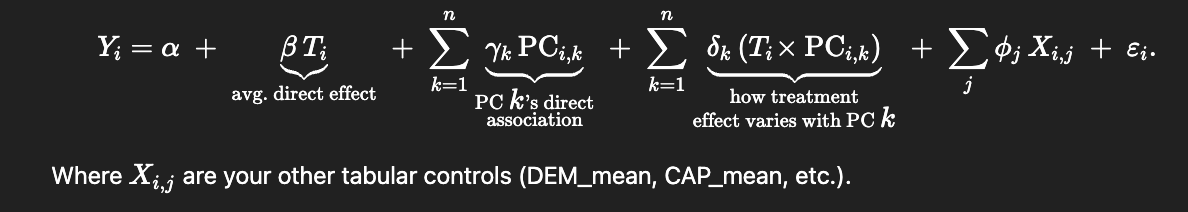

In [60]:
pc_cols     = [f'PC{k}'    for k in range(1, n+1)]

# Build DataFrame columns
# (Assuming df['T_PCk'] already computed as T * PCk)
X_cols = [TREAT] + pc_cols + inter_cols + COVS

# Prepare design matrices
X_img_cov = sm.add_constant(df[X_cols])
Y = df[OUTCOME]

# Fit
model_img_cov = sm.OLS(Y, X_img_cov).fit()
print(model_img_cov.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     445.2
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        14:10:36   Log-Likelihood:                 3472.9
No. Observations:                3565   AIC:                            -6818.
Df Residuals:                    3501   BIC:                            -6422.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0068      0.019     -0.353      0.7

In [61]:
# 1) the main treat coefficient
β_t = model_img_cov.params['wet_mean']

# 2) the interaction coefficients
inter_cols = [f'T_PC{k}' for k in range(1, 11)]
β_int = model_img_cov.params[inter_cols].sum()

# 3) total “average” treatment effect per unit change in wet_mean when all PCs = 1
β_total = β_t + β_int

print("Estimated ATE components from image‐augmented regression (Also in Covariates):")
print(f"β_treatment = {β_t:.4f}")
print(f"sum of β_{ '{'}T\\_PC1…T\\_PC10{'}'} = {β_int:.4f}")
print(f"β_treatment + ∑β_interactions = {β_total:.4f}")

Estimated ATE components from image‐augmented regression (Also in Covariates):
β_treatment = 0.9637
sum of β_{T\_PC1…T\_PC10} = -0.0514
β_treatment + ∑β_interactions = 0.9122


In [48]:
### TRUE ATE

print("TRUE Direct ATE:", np.mean(tab_df['theta_mean']))
print("TRUE Indirect ATE:", np.mean(tab_df['theta_out_mean']))
print("TRUE Total ATE:", np.mean(tab_df['theta_mean'] + tab_df['theta_out_mean']))

TRUE Direct ATE: 0.9756534912214624
TRUE Indirect ATE: 0.2825628238517222
TRUE Total ATE: 1.2582163150731844
